In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive

/content/drive/My Drive


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

CPU (s):
3.262742194000026
GPU (s):
0.10515487899999698
GPU speedup over CPU: 31x


In [7]:
!pip install torchmeta
!pip install torch
!pip install torchvision

In [8]:
#utils
import torch

from collections import OrderedDict
from torchmeta.modules import MetaModule


def compute_accuracy(logits, targets):
    """Compute the accuracy"""
    with torch.no_grad():
        _, predictions = torch.max(logits, dim=1)
        accuracy = torch.mean(predictions.eq(targets).float())
    return accuracy.item()

def tensors_to_device(tensors, device=torch.device('cpu')):
    """Place a collection of tensors in a specific device"""
    if isinstance(tensors, torch.Tensor):
        return tensors.to(device=device)
    elif isinstance(tensors, (list, tuple)):
        return type(tensors)(tensors_to_device(tensor, device=device)
            for tensor in tensors)
    elif isinstance(tensors, (dict, OrderedDict)):
        return type(tensors)([(name, tensors_to_device(tensor, device=device))
            for (name, tensor) in tensors.items()])
    else:
        raise NotImplementedError()

class ToTensor1D(object):
    """Convert a `numpy.ndarray` to tensor. Unlike `ToTensor` from torchvision,
    this converts numpy arrays regardless of the number of dimensions.

    Converts automatically the array to `float32`.
    """
    def __call__(self, array):
        return torch.from_numpy(array.astype('float32'))

    def __repr__(self):
        return self.__class__.__name__ + '()'


In [9]:
#model
import torch.nn as nn

from collections import OrderedDict
from torchmeta.modules import (MetaModule, MetaConv2d, MetaBatchNorm2d,
                               MetaSequential, MetaLinear)


def conv_block(in_channels, out_channels, **kwargs):
    return MetaSequential(OrderedDict([
        ('conv', MetaConv2d(in_channels, out_channels, **kwargs)),
        ('norm', nn.BatchNorm2d(out_channels, momentum=1.,
            track_running_stats=False)),
        ('relu', nn.ReLU()),
        ('pool', nn.MaxPool2d(2))
    ]))

class MetaConvModel(MetaModule):
    """4-layer Convolutional Neural Network architecture from [1].

    Parameters
    ----------
    in_channels : int
        Number of channels for the input images.

    out_features : int
        Number of classes (output of the model).

    hidden_size : int (default: 64)
        Number of channels in the intermediate representations.

    feature_size : int (default: 64)
        Number of features returned by the convolutional head.

    References
    ----------
    .. [1] Finn C., Abbeel P., and Levine, S. (2017). Model-Agnostic Meta-Learning
           for Fast Adaptation of Deep Networks. International Conference on
           Machine Learning (ICML) (https://arxiv.org/abs/1703.03400)
    """
    def __init__(self, in_channels, out_features, hidden_size=64, feature_size=64):
        super(MetaConvModel, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size
        self.feature_size = feature_size

        self.features = MetaSequential(OrderedDict([
            ('layer1', conv_block(in_channels, hidden_size, kernel_size=3,
                                  stride=1, padding=1, bias=True)),
            ('layer2', conv_block(hidden_size, hidden_size, kernel_size=3,
                                  stride=1, padding=1, bias=True)),
            ('layer3', conv_block(hidden_size, hidden_size, kernel_size=3,
                                  stride=1, padding=1, bias=True)),
            ('layer4', conv_block(hidden_size, hidden_size, kernel_size=3,
                                  stride=1, padding=1, bias=True))
        ]))
        self.classifier = MetaLinear(feature_size, out_features, bias=True)

    def forward(self, inputs, params=None):
        features = self.features(inputs, params=self.get_subdict(params, 'features'))
        features = features.view((features.size(0), -1))
        logits = self.classifier(features, params=self.get_subdict(params, 'classifier'))
        return logits

class MetaMLPModel(MetaModule):
    """Multi-layer Perceptron architecture from [1].

    Parameters
    ----------
    in_features : int
        Number of input features.

    out_features : int
        Number of classes (output of the model).

    hidden_sizes : list of int
        Size of the intermediate representations. The length of this list
        corresponds to the number of hidden layers.

    References
    ----------
    .. [1] Finn C., Abbeel P., and Levine, S. (2017). Model-Agnostic Meta-Learning
           for Fast Adaptation of Deep Networks. International Conference on
           Machine Learning (ICML) (https://arxiv.org/abs/1703.03400)
    """
    def __init__(self, in_features, out_features, hidden_sizes):
        super(MetaMLPModel, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_sizes = hidden_sizes

        layer_sizes = [in_features] + hidden_sizes
        self.features = MetaSequential(OrderedDict([('layer{0}'.format(i + 1),
            MetaSequential(OrderedDict([
                ('linear', MetaLinear(hidden_size, layer_sizes[i + 1], bias=True)),
                ('relu', nn.ReLU())
            ]))) for (i, hidden_size) in enumerate(layer_sizes[:-1])]))
        self.classifier = MetaLinear(hidden_sizes[-1], out_features, bias=True)

    def forward(self, inputs, params=None):
        features = self.features(inputs, params=self.get_subdict(params, 'features'))
        logits = self.classifier(features, params=self.get_subdict(params, 'classifier'))
        return logits

def ModelConvOmniglot(out_features, hidden_size=64):
    return MetaConvModel(1, out_features, hidden_size=hidden_size,
                         feature_size=hidden_size)

def ModelConvMiniImagenet(out_features, hidden_size=64):
    return MetaConvModel(3, out_features, hidden_size=hidden_size,
                         feature_size=5 * 5 * hidden_size)

def ModelMLPSinusoid(hidden_sizes=[40, 40]):
    return MetaMLPModel(1, 1, hidden_sizes)

if __name__ == '__main__':
    model = ModelMLPSinusoid()


In [10]:
# maml
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

from collections import OrderedDict
from torchmeta.utils import gradient_update_parameters

__all__ = ['ModelAgnosticMetaLearning', 'MAML', 'FOMAML']


class ModelAgnosticMetaLearning(object):
    """Meta-learner class for Model-Agnostic Meta-Learning [1].

    Parameters
    ----------
    model : `torchmeta.modules.MetaModule` instance
        The model.

    optimizer : `torch.optim.Optimizer` instance, optional
        The optimizer for the outer-loop optimization procedure. This argument
        is optional for evaluation.

    step_size : float (default: 0.1)
        The step size of the gradient descent update for fast adaptation
        (inner-loop update).

    first_order : bool (default: False)
        If `True`, then the first-order approximation of MAML is used.

    learn_step_size : bool (default: False)
        If `True`, then the step size is a learnable (meta-trained) additional
        argument [2].

    per_param_step_size : bool (default: False)
        If `True`, then the step size parameter is different for each parameter
        of the model. Has no impact unless `learn_step_size=True`.

    num_adaptation_steps : int (default: 1)
        The number of gradient descent updates on the loss function (over the
        training dataset) to be used for the fast adaptation on a new task.

    scheduler : object in `torch.optim.lr_scheduler`, optional
        Scheduler for the outer-loop optimization [3].

    loss_function : callable (default: `torch.nn.functional.cross_entropy`)
        The loss function for both the inner and outer-loop optimization.
        Usually `torch.nn.functional.cross_entropy` for a classification
        problem, of `torch.nn.functional.mse_loss` for a regression problem.

    device : `torch.device` instance, optional
        The device on which the model is defined.

    References
    ----------
    .. [1] Finn C., Abbeel P., and Levine, S. (2017). Model-Agnostic Meta-Learning
           for Fast Adaptation of Deep Networks. International Conference on
           Machine Learning (ICML) (https://arxiv.org/abs/1703.03400)

    .. [2] Li Z., Zhou F., Chen F., Li H. (2017). Meta-SGD: Learning to Learn
           Quickly for Few-Shot Learning. (https://arxiv.org/abs/1707.09835)

    .. [3] Antoniou A., Edwards H., Storkey A. (2018). How to train your MAML.
           International Conference on Learning Representations (ICLR).
           (https://arxiv.org/abs/1810.09502)
    """
    def __init__(self, model, optimizer=None, step_size=0.1, first_order=False,
                 learn_step_size=False, per_param_step_size=False,
                 num_adaptation_steps=1, scheduler=None,
                 loss_function=F.cross_entropy, device=None):
        self.model = model.to(device=device)
        self.optimizer = optimizer
        self.step_size = step_size
        self.first_order = first_order
        self.num_adaptation_steps = num_adaptation_steps
        self.scheduler = scheduler
        self.loss_function = loss_function
        self.device = device

        if per_param_step_size:
            self.step_size = OrderedDict((name, torch.tensor(step_size,
                dtype=param.dtype, device=self.device,
                requires_grad=learn_step_size)) for (name, param)
                in model.meta_named_parameters())
        else:
            self.step_size = torch.tensor(step_size, dtype=torch.float32,
                device=self.device, requires_grad=learn_step_size)

        if (self.optimizer is not None) and learn_step_size:
            self.optimizer.add_param_group({'params': self.step_size.values()
                if per_param_step_size else [self.step_size]})
            if scheduler is not None:
                for group in self.optimizer.param_groups:
                    group.setdefault('initial_lr', group['lr'])
                self.scheduler.base_lrs([group['initial_lr']
                    for group in self.optimizer.param_groups])

    def get_outer_loss(self, batch):
        if 'test' not in batch:
            raise RuntimeError('The batch does not contain any test dataset.')

        _, test_targets = batch['test']
        num_tasks = test_targets.size(0)
        is_classification_task = (not test_targets.dtype.is_floating_point)
        results = {
            'num_tasks': num_tasks,
            'inner_losses': np.zeros((self.num_adaptation_steps,
                num_tasks), dtype=np.float32),
            'outer_losses': np.zeros((num_tasks,), dtype=np.float32),
            'mean_outer_loss': 0.
        }
        if is_classification_task:
            results.update({
                'accuracies_before': np.zeros((num_tasks,), dtype=np.float32),
                'accuracies_after': np.zeros((num_tasks,), dtype=np.float32)
            })

        mean_outer_loss = torch.tensor(0., device=self.device)
        for task_id, (train_inputs, train_targets, test_inputs, test_targets) \
                in enumerate(zip(*batch['train'], *batch['test'])):
            params, adaptation_results = self.adapt(train_inputs, train_targets,
                is_classification_task=is_classification_task,
                num_adaptation_steps=self.num_adaptation_steps,
                step_size=self.step_size, first_order=self.first_order)

            results['inner_losses'][:, task_id] = adaptation_results['inner_losses']
            if is_classification_task:
                results['accuracies_before'][task_id] = adaptation_results['accuracy_before']

            with torch.set_grad_enabled(self.model.training):
                test_logits = self.model(test_inputs, params=params)
                outer_loss = self.loss_function(test_logits, test_targets)
                results['outer_losses'][task_id] = outer_loss.item()
                mean_outer_loss += outer_loss

            if is_classification_task:
                results['accuracies_after'][task_id] = compute_accuracy(
                    test_logits, test_targets)

        mean_outer_loss.div_(num_tasks)
        results['mean_outer_loss'] = mean_outer_loss.item()

        return mean_outer_loss, results

    def adapt(self, inputs, targets, is_classification_task=None,
              num_adaptation_steps=1, step_size=0.1, first_order=False):
        if is_classification_task is None:
            is_classification_task = (not targets.dtype.is_floating_point)
        params = None

        results = {'inner_losses': np.zeros(
            (num_adaptation_steps,), dtype=np.float32)}

        for step in range(num_adaptation_steps):
            logits = self.model(inputs, params=params)
            inner_loss = self.loss_function(logits, targets)
            results['inner_losses'][step] = inner_loss.item()

            if (step == 0) and is_classification_task:
                results['accuracy_before'] = compute_accuracy(logits, targets)

            self.model.zero_grad()
            params = gradient_update_parameters(self.model, inner_loss,
                step_size=step_size, params=params,
                first_order=(not self.model.training) or first_order)

        return params, results

    def train(self, dataloader, max_batches=500, verbose=True, **kwargs):
        # with tqdm(total=max_batches, disable=not verbose, **kwargs) as pbar:
        acc_list = []
        loss_list=[]
        with tqdm(total=max_batches,**kwargs) as pbar:
            for results in self.train_iter(dataloader, max_batches=max_batches):
                # pbar.update(1)
                postfix = {'loss': '{0:.4f}'.format(results['mean_outer_loss'])}
                loss_list.append(results['mean_outer_loss'])
                if 'accuracies_after' in results:
                    postfix['accuracy'] = '{0:.4f}'.format(
                        np.mean(results['accuracies_after']))          
                    
                    acc_list.append(np.mean(results['accuracies_after']))
                pbar.set_postfix(**postfix)                  
        return (acc_list,loss_list)

    def train_iter(self, dataloader, max_batches=500):
        if self.optimizer is None:
            raise RuntimeError('Trying to call `train_iter`, while the '
                'optimizer is `None`. In order to train `{0}`, you must '
                'specify a Pytorch optimizer as the argument of `{0}` '
                '(eg. `{0}(model, optimizer=torch.optim.SGD(model.'
                'parameters(), lr=0.01), ...).'.format(__class__.__name__))
        num_batches = 0
        self.model.train()
        while num_batches < max_batches:
            for batch in dataloader:
                if num_batches >= max_batches:
                    break

                if self.scheduler is not None:
                    self.scheduler.step(epoch=num_batches)

                self.optimizer.zero_grad()

                batch = tensors_to_device(batch, device=self.device)
                outer_loss, results = self.get_outer_loss(batch)
                yield results

                outer_loss.backward()
                self.optimizer.step()

                num_batches += 1

    def evaluate(self, dataloader, max_batches=500, verbose=True, **kwargs):
        mean_outer_loss, mean_accuracy, count = 0., 0., 0

        # with tqdm(total=max_batches, disable=not verbose, **kwargs) as pbar:
        with tqdm(total=max_batches, **kwargs) as pbar:
            for results in self.evaluate_iter(dataloader, max_batches=max_batches):
                pbar.update(1)
                count += 1
                mean_outer_loss += (results['mean_outer_loss']
                    - mean_outer_loss) / count
                postfix = {'loss': '{0:.4f}'.format(mean_outer_loss)}                
                if 'accuracies_after' in results:
                    mean_accuracy += (np.mean(results['accuracies_after'])
                        - mean_accuracy) / count
                    postfix['accuracy'] = '{0:.4f}'.format(mean_accuracy)                    
                pbar.set_postfix(**postfix)
        mean_results = {'mean_outer_loss': mean_outer_loss}
        if 'accuracies_after' in results:
            mean_results['accuracies_after'] = mean_accuracy

        return (mean_results)

    def evaluate_iter(self, dataloader, max_batches=500):
        num_batches = 0
        self.model.eval()
        while num_batches < max_batches:
            for batch in dataloader:
                if num_batches >= max_batches:
                    break

                batch = tensors_to_device(batch, device=self.device)
                _, results = self.get_outer_loss(batch)
                yield results

                num_batches += 1

MAML = ModelAgnosticMetaLearning

class FOMAML(ModelAgnosticMetaLearning):
    def __init__(self, model, optimizer=None, step_size=0.1,
                 learn_step_size=False, per_param_step_size=False,
                 num_adaptation_steps=1, scheduler=None,
                 loss_function=F.cross_entropy, device=None):
        super(FOMAML, self).__init__(model, optimizer=optimizer, first_order=True,
            step_size=step_size, learn_step_size=learn_step_size,
            per_param_step_size=per_param_step_size,
            num_adaptation_steps=num_adaptation_steps, scheduler=scheduler,
            loss_function=loss_function, device=device)


In [11]:
# meta_sgd
import torch
import torch.nn.functional as F
import numpy as np

__all__ = ['MetaSGD']


class MetaSGD(ModelAgnosticMetaLearning):
    def __init__(self, model, optimizer=None, init_step_size=0.1,
                 num_adaptation_steps=1, scheduler=None,
                 loss_function=F.cross_entropy, device=None):
        super(MetaSGD, self).__init__(model, optimizer=optimizer,
            step_size=init_step_size, learn_step_size=True,
            per_param_step_size=True, num_adaptation_steps=num_adaptation_steps,
            scheduler=scheduler, loss_function=loss_function, device=device)


In [12]:
#datasets
import torch.nn.functional as F

from collections import namedtuple
from torchmeta.datasets import Omniglot, MiniImagenet
from torchmeta.toy import Sinusoid
from torchmeta.transforms import ClassSplitter, Categorical, Rotation
from torchvision.transforms import ToTensor, Resize, Compose

Benchmark = namedtuple('Benchmark', 'meta_train_dataset meta_val_dataset '
                                    'meta_test_dataset model loss_function')

def get_benchmark_by_name(name,
                          folder,
                          numWays,
                          numShots,
                          numShotsTest,
                          hidden_size=None):
    dataset_transform = ClassSplitter(shuffle=True,
                                      num_train_per_class=numShots,
                                      num_test_per_class=numShotsTest)
    if name == 'sinusoid':
        transform = ToTensor1D()

        meta_train_dataset = Sinusoid(numShots + numShotsTest,
                                      num_tasks=1000000,
                                      transform=transform,
                                      target_transform=transform,
                                      dataset_transform=dataset_transform)
        meta_val_dataset = Sinusoid(numShots + numShotsTest,
                                    num_tasks=1000000,
                                    transform=transform,
                                    target_transform=transform,
                                    dataset_transform=dataset_transform)
        meta_test_dataset = Sinusoid(numShots + numShotsTest,
                                     num_tasks=1000000,
                                     transform=transform,
                                     target_transform=transform,
                                     dataset_transform=dataset_transform)

        model = ModelMLPSinusoid(hidden_sizes=[40, 40])
        loss_function = F.mse_loss

    elif name == 'omniglot':
        class_augmentations = [Rotation([90, 180, 270])]
        transform = Compose([Resize(28), ToTensor()])

        meta_train_dataset = Omniglot(folder,
                                      transform=transform,
                                      target_transform=Categorical(numWays),
                                      num_classes_per_task=numWays,
                                      meta_train=True,
                                      class_augmentations=class_augmentations,
                                      dataset_transform=dataset_transform,
                                      download=True)
        meta_val_dataset = Omniglot(folder,
                                    transform=transform,
                                    target_transform=Categorical(numWays),
                                    num_classes_per_task=numWays,
                                    meta_val=True,
                                    class_augmentations=class_augmentations,
                                    dataset_transform=dataset_transform)
        meta_test_dataset = Omniglot(folder,
                                     transform=transform,
                                     target_transform=Categorical(numWays),
                                     num_classes_per_task=numWays,
                                     meta_test=True,
                                     dataset_transform=dataset_transform)

        model = ModelConvOmniglot(numWays, hidden_size=hidden_size)
        loss_function = F.cross_entropy

    elif name == 'miniimagenet':
        transform = Compose([Resize(84), ToTensor()])

        meta_train_dataset = MiniImagenet(folder,
                                          transform=transform,
                                          target_transform=Categorical(numWays),
                                          num_classes_per_task=numWays,
                                          meta_train=True,
                                          dataset_transform=dataset_transform,
                                          download=True)
        meta_val_dataset = MiniImagenet(folder,
                                        transform=transform,
                                        target_transform=Categorical(numWays),
                                        num_classes_per_task=numWays,
                                        meta_val=True,
                                        dataset_transform=dataset_transform)
        meta_test_dataset = MiniImagenet(folder,
                                         transform=transform,
                                         target_transform=Categorical(numWays),
                                         num_classes_per_task=numWays,
                                         meta_test=True,
                                         dataset_transform=dataset_transform)

        model = ModelConvMiniImagenet(numWays, hidden_size=hidden_size)
        loss_function = F.cross_entropy

    else:
        raise NotImplementedError('Unknown dataset `{0}`.'.format(name))

    return Benchmark(meta_train_dataset=meta_train_dataset,
                     meta_val_dataset=meta_val_dataset,
                     meta_test_dataset=meta_test_dataset,
                     model=model,
                     loss_function=loss_function)


INFO:root:Saving configuration file in `/content/drive/My Drive/out/2020-11-17_080006/config.json`
Epoch 1: 100%|██████████| 100/100 [02:16<00:00,  1.37s/it, accuracy=0.9232, loss=0.3034]


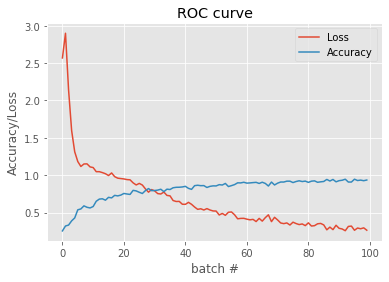

In [23]:
#train
#************* Please create 2 folders on your Drive called: data , out**************
import torch
import math
import os
from os.path import isfile, join
import time
import json
import logging

from torchmeta.utils.data import BatchMetaDataLoader

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# General
folder = os.path.join(".",'data')#Path to the folder the data is downloaded to.
dataset = 'omniglot'#Name of the dataset (default: omniglot).
outputFolder = os.path.join(".",'out')#Path to the output folder to save the model.
numWays=5 #Number of classes per task (N in "N-way", default: 5).
numShots = 5 #Number of training example per class (k in "k-shot", default: 5).
numShotsTest = 15 #Number of test example per class. If negative, same as the number of training examples `--num-shots` (default: 15).

# Model
hiddenSize = 64 #Number of channels in each convolution layer of the VGG network (default: 64).

# Optimization
batchSize =32 #Number of tasks in a batch of tasks (default: 25).').
numSteps = 1 #Number of fast adaptation steps, ie. gradient descent updates (default: 1).
numEpochs = 1 #Number of epochs of meta-training (default: 50).
numBatches = 100 #Number of batch of tasks per epoch (default: 100).
stepSize = 0.4 #Size of the fast adaptation step, ie. learning rate in the gradient descent update (default: 0.1).
firstOrder = False #Use the first order approximation, do not use higher-order derivatives during meta-optimization.
metaLr =0.001 #Learning rate for the meta-optimizer (optimization of the outer loss). The default optimizer is Adam (default: 1e-3).

# Misc
numWorkers = 8 #Number of workers to use for data-loading (default: 1).
verbose = False
useCuda = True

# 
logging.basicConfig(level=logging.DEBUG if verbose else logging.INFO)
device = torch.device('cuda' if useCuda
                        and torch.cuda.is_available() else 'cpu')
    
if (outputFolder is not None):
    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)
        logging.debug('Creating folder `{0}`'.format(outputFolder))

    folderOutCreated = os.path.join(outputFolder,
                          time.strftime('%Y-%m-%d_%H%M%S'))
    os.makedirs(folderOutCreated)
    logging.debug('Creating folder `{0}`'.format(folderOutCreated))

    folder = os.path.abspath(folder)
    modelPath = os.path.abspath(os.path.join(folderOutCreated, 'model.th'))
    vars = {"folder" : folder, 
            "dataset" : dataset,
            "outputFolder" : outputFolder,
            "numWays" : numWays,
            "numShots" : numShots,
            "numShotsTest" : numShotsTest,
            "hiddenSize" : hiddenSize,
            "batchSize" : batchSize, 
            "numSteps" : numSteps ,
            "numEpochs" : numEpochs ,
            "numBatches" : numBatches ,
            "stepSize" : stepSize ,
            "firstOrder" : firstOrder,
            "metaLr" : metaLr, 
            "numWorkers" : numWorkers, 
            "verbose" : verbose,
            "useCuda" : useCuda,
            "modelPath" : modelPath}
    # Save the configuration in a config.json file
    with open(os.path.join(folderOutCreated, 'config.json'), 'w') as f:
        json.dump(vars, f, indent=2)
    logging.info('Saving configuration file in `{0}`'.format(
                  os.path.abspath(os.path.join(folderOutCreated, 'config.json'))))

benchmark = get_benchmark_by_name(dataset,
                                      folder,
                                      numWays,
                                      numShots,
                                      numShotsTest,
                                      hidden_size=hiddenSize)

meta_train_dataloader = BatchMetaDataLoader(benchmark.meta_train_dataset,
                                                batch_size=batchSize,
                                                shuffle=True,
                                                num_workers=numWorkers,
                                                pin_memory=True)
meta_val_dataloader = BatchMetaDataLoader(benchmark.meta_val_dataset,
                                              batch_size=batchSize,
                                              shuffle=True,
                                              num_workers=numWorkers,
                                              pin_memory=True)

meta_optimizer = torch.optim.Adam(benchmark.model.parameters(), lr=metaLr)
metalearner = ModelAgnosticMetaLearning(benchmark.model,
                                            meta_optimizer,
                                            first_order=firstOrder,
                                            num_adaptation_steps=numSteps,
                                            step_size=stepSize,
                                            loss_function=benchmark.loss_function,
                                            device=device)

best_value = None
accuracy_epoch = []
loss_epoch = []

# Training loop
epoch_desc = 'Epoch {{0: <{0}d}}'.format(1 + int(math.log10(numEpochs)))
for epoch in range(numEpochs):
    (accuracy_list, loss_list) = metalearner.train(meta_train_dataloader,
                          max_batches=numBatches,
                          verbose=verbose,
                          desc='Training',
                          leave=False)
    results = metalearner.evaluate(meta_val_dataloader,
                                       max_batches=numBatches,
                                       verbose=verbose,
                                       desc=epoch_desc.format(epoch + 1))

    # Plot
    plt.style.use("ggplot")
    plt.figure()    
    plt.plot(np.arange(0, numBatches), loss_list, label="Loss")
    plt.plot(np.arange(0, numBatches), accuracy_list, label="Accuracy")
    plt.title("ROC curve")
    plt.xlabel("batch #")
    plt.ylabel("Accuracy/Loss")
    plt.legend()
    plt.show()
    # Save best model
    if 'accuracies_after' in results:
        if (best_value is None) or (best_value < results['accuracies_after']):
            best_value = results['accuracies_after']
            save_model = True
    elif (best_value is None) or (best_value > results['mean_outer_loss']):
        best_value = results['mean_outer_loss']
        save_model = True
    else:
        save_model = False


    if save_model and (outputFolder is not None):
        with open(modelPath, 'wb') as f:
            torch.save(benchmark.model.state_dict(), f)           

if hasattr(benchmark.meta_train_dataset, 'close'):
    benchmark.meta_train_dataset.close()
    benchmark.meta_val_dataset.close()
 

In [24]:
#test
    
config = os.path.abspath(os.path.join(folderOutCreated, 'config.json')) #Path to the configuration file .
folder = None #Path to the folder the data is downloaded to.(default: path defined in configuration file).

# Optimization
numSteps = -1 #Number of fast adaptation steps, ie. gradient descent updates (default: number of steps in configuration file).
numBatches = -1 #Number of batch of tasks per epoch (default: number of batches in configuration file).

# Misc
numWorkers = 1 #Number of workers to use for data-loading (default: 1).
verbose = False
useCuda = True   
#
with open(config, 'r') as f:
    config = json.load(f)

if folder is not None:
    config['folder'] = folder
if numSteps > 0:
    config['numSteps'] = numSteps
if numBatches > 0:
    config['numBatches'] = numBatches

device = torch.device('cuda' if useCuda
                      and torch.cuda.is_available() else 'cpu')

benchmark = get_benchmark_by_name(config['dataset'],
                                      config['folder'],
                                      config['numWays'],
                                      config['numShots'],
                                      config['numShotsTest'],
                                      hidden_size=config['hiddenSize'])

with open(config['modelPath'], 'rb') as f:
    benchmark.model.load_state_dict(torch.load(f, map_location=device))

meta_test_dataloader = BatchMetaDataLoader(benchmark.meta_test_dataset,
                                               batch_size=config['batchSize'],
                                               shuffle=True,
                                               num_workers=numWorkers,
                                               pin_memory=True)
metalearner = ModelAgnosticMetaLearning(benchmark.model,
                                            first_order=config['firstOrder'],
                                            num_adaptation_steps=config['numSteps'],
                                            step_size=config['stepSize'],
                                            loss_function=benchmark.loss_function,
                                            device= device)

results = metalearner.evaluate(meta_test_dataloader,
                                   max_batches=config['numBatches'],
                                   verbose=verbose,
                                   desc='Test')
# Save results
dirname = os.path.dirname(config['modelPath'])
with open(os.path.join(dirname, 'results.json'), 'w') as f:
    json.dump(results, f)


Test: 100%|██████████| 100/100 [02:20<00:00,  1.40s/it, accuracy=0.9030, loss=0.3418]
